Import Package
=======================

In [1]:
pip install pytorch-nlp

In [2]:
import torch
from torchnlp.word_to_vector import GloVe
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd.variable import Variable
import seaborn as sns
import numpy as np

Import dataset
=========================

In [3]:
numwords = 50000
max = 200
from tensorflow.keras.datasets import imdb
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) \
= imdb.load_data(num_words=numwords, skip_top=100, seed=500)
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items() if i < numwords}

In [4]:
Y_train = torch.from_numpy(Y_train_numpy).type(torch.float)
Y_test = torch.from_numpy(Y_test_numpy).type(torch.float)
# Y_train = torch.from_numpy(Y_train_numpy).type(torch.float).cuda()
# Y_test = torch.from_numpy(Y_test_numpy).type(torch.float).cuda()
print(f"Y_train is {Y_train.size()}, Y_test is {Y_test.size()}")

Y_train is torch.Size([25000]), Y_test is torch.Size([25000])


Import Glove
===========================

In [6]:
glove = GloVe(name='6B', dim=50)

In [6]:
glove['cat', 'dog']

tensor([[ 0.4528, -0.5011, -0.5371, -0.0157,  0.2219,  0.5460, -0.6730, -0.6891,
          0.6349, -0.1973,  0.3368,  0.7735,  0.9009,  0.3849,  0.3837,  0.2657,
         -0.0806,  0.6109, -1.2894, -0.2231, -0.6158,  0.2170,  0.3561,  0.4450,
          0.6089, -1.1633, -1.1579,  0.3612,  0.1047, -0.7832,  1.4352,  0.1863,
         -0.2611,  0.8328, -0.2312,  0.3248,  0.1449, -0.4455,  0.3350, -0.9595,
         -0.0975,  0.4814, -0.4335,  0.6945,  0.9104, -0.2817,  0.4164, -1.2609,
          0.7128,  0.2378],
        [ 0.1101, -0.3878, -0.5762, -0.2771,  0.7052,  0.5399, -1.0786, -0.4015,
          1.1504, -0.5678,  0.0039,  0.5288,  0.6456,  0.4726,  0.4855, -0.1841,
          0.1801,  0.9140, -1.1979, -0.5778, -0.3799,  0.3361,  0.7720,  0.7556,
          0.4551, -1.7671, -1.0503,  0.4257,  0.4189, -0.6833,  1.5673,  0.2768,
         -0.6171,  0.6464, -0.0770,  0.3712,  0.1308, -0.4514,  0.2540, -0.7439,
         -0.0862,  0.2407, -0.6482,  0.8355,  1.2502, -0.5138,  0.0422, -0.8812,


In [ ]:
l = [id2word[id] for id in X_train_numpy[1]]
input = glove[[id2word[id] for id in X_train_numpy[1]]]
input.size()

torch.Size([203, 50])

LSTM
=======================
1. input_size = feature dim of word vector, here we use glove
(dim=50) so input_size = 50  
2. input: [1, word_num, input_size] = [batch, seq_len, input_size]

In [7]:
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ishidden=True):
        super(LSTM1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.ishidden = ishidden
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.logr = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, input, hidden, state):  # input: batch, seq_len, input_size
        input = input.view(1, input.size()[0], input.size()[1])
        output, (hn, cn) = self.lstm(input, (hidden, state))
        if self.ishidden:
            output = hn.view(1, -1)
            output = self.logr(output).view(1)
        else:
            output = torch.mean(output, [0, 1])
            output = self.logr(output).view(1)
        
        return output

    def initHiddenState(self):
        return torch.zeros(self.hidden_size * self.num_layers).view(self.num_layers, 1, -1).cuda(), \
        torch.zeros(self.hidden_size * self.num_layers).view(self.num_layers, 1, -1).cuda()

Implement
=================

train and store
-----------------------

epoch is 199, acc_rate is 0.54, loss is 0.2520014038681984
epoch is 399, acc_rate is 0.66, loss is 0.22910019814968108
epoch is 599, acc_rate is 0.58, loss is 0.24264368310570716
epoch is 799, acc_rate is 0.64, loss is 0.20755899483337997
epoch is 999, acc_rate is 0.7, loss is 0.1969007766339928
epoch is 1199, acc_rate is 0.76, loss is 0.15932307851736766
epoch is 1399, acc_rate is 0.76, loss is 0.13915322449072845
epoch is 1599, acc_rate is 0.8, loss is 0.1437810352242233
epoch is 1799, acc_rate is 0.84, loss is 0.09491897620119596
epoch is 1999, acc_rate is 0.82, loss is 0.13229570295518442
epoch is 2199, acc_rate is 0.94, loss is 0.0945670133235899
epoch is 2399, acc_rate is 0.94, loss is 0.06773943075504231
epoch is 2599, acc_rate is 0.88, loss is 0.09884431686458015
epoch is 2799, acc_rate is 0.94, loss is 0.053401567766331925
epoch is 2999, acc_rate is 0.96, loss is 0.04719887949981196
epoch is 3199, acc_rate is 0.88, loss is 0.09217439776194418
epoch is 3399, acc_rate is 0.92, l

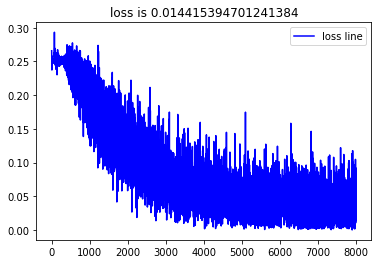

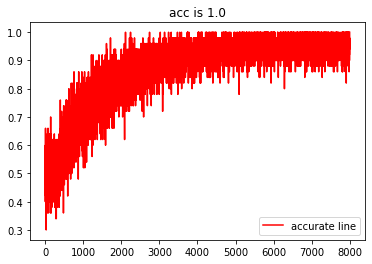

In [8]:
from tqdm.notebook import tnrange, tqdm_notebook

for hidden_layer in [200]:
    lstm1 = LSTM1(50, hidden_layer, 1, 2, ishidden=False).cuda()
    lstm1_optimizer = optim.Adam(lstm1.parameters(), lr = 0.001)

    # loss function
    loss_function = nn.MSELoss()

    # init acc
    acc = 0

    # batch size
    batch_size = 50

    # list
    epoch_list = []
    loss_list = []
    acc_rate_list = []

    for ep in tnrange(8000):

        acc = 0
        loss_total = 0

        for i in range(batch_size):

            # t
            t = (ep * batch_size + i) % 25000

            # initial hidden layer
            h_0, s_0 = lstm1.initHiddenState()
            # initial learnable parameters
            lstm1.zero_grad()

            input = glove[[id2word[id] for id in X_train_numpy[t]]].cuda()
            output = lstm1(input, h_0, s_0)
            
            loss = loss_function(output, Y_train[t].view(1))
            # print((output.size(), Y_train[i].view(1).size()))
            loss.backward()
            nn.utils.clip_grad_norm_(lstm1.parameters(), 5)
            lstm1_optimizer.step()

            # calculate accurate rate and loss
            pred = np.round(output.cpu().detach().numpy())
            if pred[0] == Y_train[t].cpu().detach().numpy():
                acc += 1
            loss_total += loss.cpu().detach().item()
        
        acc_rate = acc / batch_size
        loss_rate = loss_total / batch_size
        if (ep + 1) % 200 == 0:
            print(f"epoch is {ep}, acc_rate is {acc_rate}, loss is {loss_rate}")

        epoch_list.append(ep)
        loss_list.append(loss_rate)
        acc_rate_list.append(acc_rate)

    fig, ax = plt.subplots()
    sns.lineplot(x=epoch_list, y=loss_list, color='blue', label='loss line', ax=ax)
    plt.title(f"loss is {loss_rate}")
    plt.show()

    fig, ax = plt.subplots()
    sns.lineplot(x=epoch_list, y=acc_rate_list, color='red', label='accurate line', ax=ax)
    plt.title(f"acc is {acc_rate}")
    plt.show()


    path = '/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/LSTM_package_' \
    + str(hidden_layer) + '.pt'
    torch.save(lstm1.state_dict(), path)


    # # test
    # N_test = Y_test_numpy.shape[0]
    # acc_test = 0
    # loss_total_test = 0
    # for t in tnrange(N_test):
    #     input = glove[[id2word[id] for id in X_test_numpy[t]]].cpu()
    #     lstm1.cpu()
    #     output = lstm1(input, h_0.cpu(), s_0.cpu()).cpu()
    #     loss_test = loss_function(output, Y_test[t].view(1).cpu())
    #     pred = np.round(output.detach().numpy())
    #     if pred[0] == Y_test[t].cpu().detach().numpy():
    #         acc_test += 1
    #     loss_total_test += loss_test
    # acc_rate_test = acc_test / N_test
    # loss_rate_test = loss_total_test / N_test
    # print(f"{hidden_layer}: loss is {loss_rate_test}, acc_rate is {acc_rate_test}")

reload
------------------

In [8]:
import torch
path = '/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/LSTM_package_200.pt'

lstm1 = LSTM1(50, 200, 1, 2, ishidden=False).cuda()
lstm1.load_state_dict(torch.load(path))
# lstm1.eval()

<All keys matched successfully>

Test
==================

In [12]:
from tqdm.notebook import tnrange, tqdm_notebook
loss_function = nn.MSELoss()

N_test = 3000

lstm1 = lstm1

# N_test = Y_test_numpy.shape[0]
acc_rate_test = 0
loss_rate_test = 0
for ep in tnrange(1):
    acc_test = 0
    loss_test = 0
    for t in tnrange(N_test):
        input = glove[[id2word[id] for id in X_test_numpy[t]]].cuda()
        h_0, s_0 = lstm1.initHiddenState()
        output = lstm1(input, h_0, s_0)
        loss_test += loss_function(output, Y_test[t].cuda().view(1))
        pred_test = np.round(output.cpu().detach().numpy())
        if pred_test[0] == Y_test[t].detach().numpy():
            acc_test += 1
        
    acc_rate_test += acc_test
    loss_rate_test += loss_test
acc_rate_test = acc_rate_test / N_test
loss_rate_test = loss_rate_test / N_test
print(f"loss is {loss_rate_test}, acc_rate is {acc_rate_test}")



loss is 0.17187240719795227, acc_rate is 0.7946666666666666
